<h2 align="center">Codebasics DL Course: Handwritten Digits Classification Using Multilayer Perceptron</h2>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

### Load the Dataset

In [2]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

data_iter = iter(train_loader)
images, labels = next(data_iter)

In [5]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
images[0].shape

torch.Size([1, 28, 28])

In [7]:
images[0].squeeze().shape

torch.Size([28, 28])

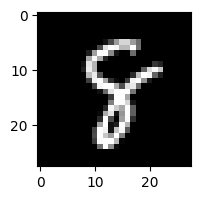

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(images[4].squeeze(), cmap="gray")
plt.show()

In [9]:
labels[4]

tensor(8)

### Train a Fully Connected Neural Network (FCNN)

In [10]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.network(x)

In [11]:
# Instantiate the model, define loss function and optimizer
model = DigitClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()          # Zero the gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                # Backpropagate
        optimizer.step()               # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.4104
Epoch [2/5], Loss: 0.1968
Epoch [3/5], Loss: 0.1436
Epoch [4/5], Loss: 0.1146
Epoch [5/5], Loss: 0.0976


In [12]:
# Testing the model
model.eval()  # Switch to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 96.80%


### Classification Report & Confusion Matrix

In [14]:
# Testing the model
model.eval()  # Switch to evaluation mode

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append labels and predictions to lists
        all_labels.extend(labels.numpy())    
        all_predicted.extend(predicted.numpy()) 

In [20]:
len(all_predicted)

10000

In [22]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.95      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predicted)
cm

array([[ 965,    0,    0,    0,    0,    4,    5,    1,    3,    2],
       [   0, 1121,    4,    3,    0,    1,    4,    0,    2,    0],
       [   8,    1,  990,    9,    0,    4,    5,   11,    4,    0],
       [   0,    0,    4,  983,    0,    5,    0,    6,    8,    4],
       [   1,    0,    7,    1,  943,    1,   10,    1,    0,   18],
       [   3,    1,    1,   10,    0,  851,    8,    2,    9,    7],
       [   9,    2,    1,    1,    1,    3,  936,    1,    4,    0],
       [   1,    6,   16,    6,    5,    0,    1,  987,    0,    6],
       [   3,    1,    4,    3,    5,    6,    5,    5,  937,    5],
       [   3,    4,    0,    6,   18,    4,    2,    4,    1,  967]],
      dtype=int64)

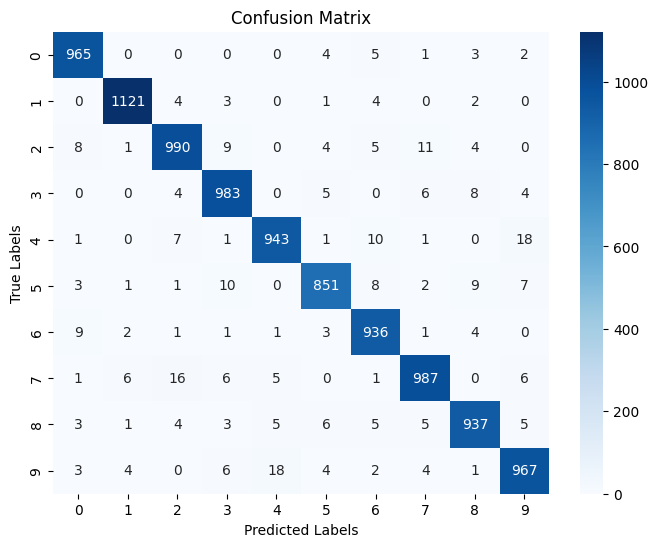

In [27]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()